<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-GenAI/blob/main/U_Net_Style_Frequency_Domain_Noise_Cancellation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Frequency-Domain Prediction with U-Net Style Model
To handle a wider range of frequencies and make the model more flexible, let's shift our approach and predict in the frequency domain (using a spectrogram representation of the signal). Specifically, we can use a U-Net style model to process the spectrogram and learn to predict the inverse signal in the frequency domain.

##Why U-Net?
U-Net is a powerful model for tasks like denoising, where capturing both local and global features is important. By working in the frequency domain, the model can directly learn the inverse signal at different frequency bands.
##Steps:
Convert the waveform to a Mel-spectrogram to work in the frequency domain.
U-Net architecture: Use a U-Net-like model to predict the inverse of the spectrogram.
Inverse the predicted spectrogram back to waveform and combine it with the input signal for cancellation.

In [ ]:
# 1. Install Dependencies
!pip install librosa matplotlib tensorflow

# 2. Import Libraries
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
# 3. Load and Downsample the Input WAV File
from google.colab import files
uploaded = files.upload()

Saving 1-9887-A-49.wav to 1-9887-A-49 (1).wav


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 28.4807
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 26.0322
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 18.1149
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 11.1089
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 6.9753
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 6.3802
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 7.4961
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 5.2472
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 5.8765
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 4.8565
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.7695
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 4.7715
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 5.3162
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 4.3518
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 5.4241
Epoch 16/30
1/1 ━━

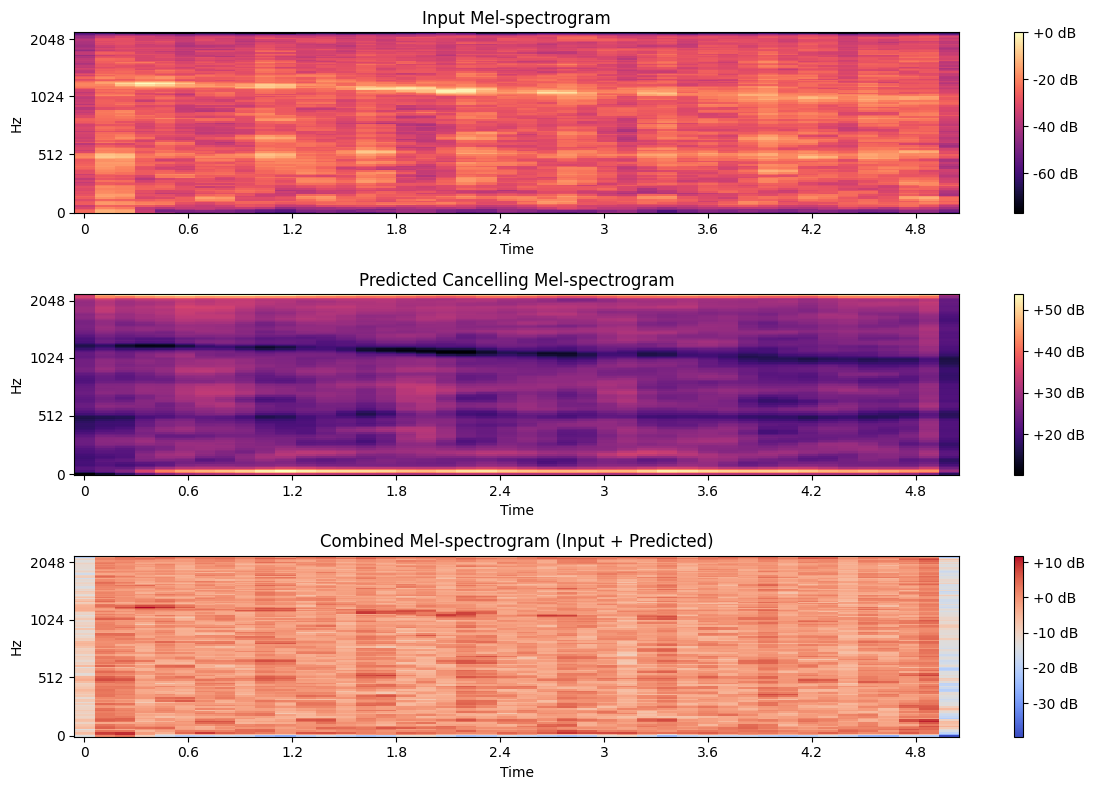

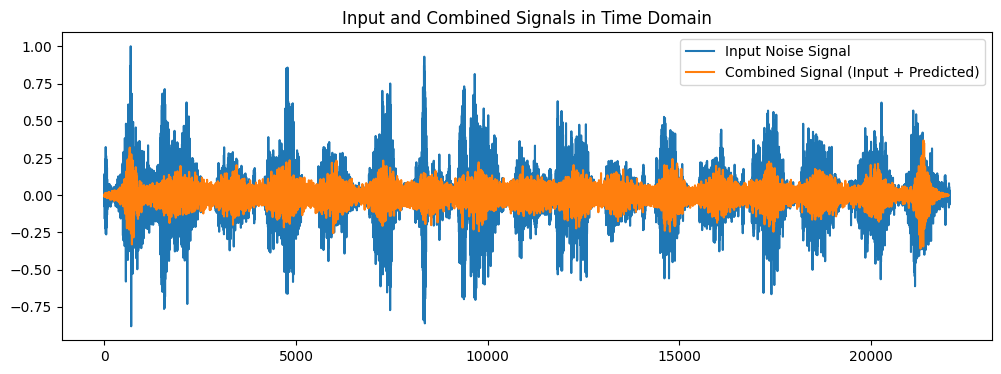

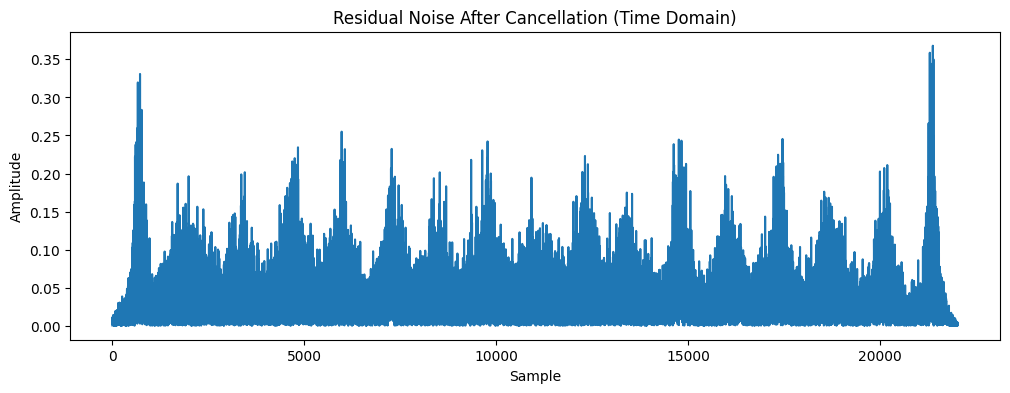

In [24]:
audio_path = list(uploaded.keys())[0]
y, sr = librosa.load(audio_path, sr=None)

# Downsample the input signal
target_sr = sr // 10  # Downsample by a factor of 10
y_downsampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

# Normalize the input signal between -1 and 1
y_downsampled = y_downsampled / np.max(np.abs(y_downsampled))

# 4. Convert the Input Signal to Mel-Spectrogram
def waveform_to_spectrogram(y, sr, n_fft=2048, hop_length=512):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.power_to_db(S, ref=np.max)  # Convert to decibel (dB) scale
    return S_db

# Generate the Mel-spectrogram of the input signal
x_train_spectrogram = waveform_to_spectrogram(y_downsampled, target_sr)
# The ideal output is the inverse (negative) of the input Mel-spectrogram
y_train_spectrogram = -x_train_spectrogram

# Reshape for training
x_train_spectrogram = x_train_spectrogram.T.reshape((1, x_train_spectrogram.shape[1], x_train_spectrogram.shape[0], 1))
y_train_spectrogram = y_train_spectrogram.T.reshape((1, y_train_spectrogram.shape[1], y_train_spectrogram.shape[0], 1))

# 5. Build a U-Net Style Model
def build_unet_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up1 = tf.keras.layers.UpSampling2D((2, 2))(conv3)
    merge1 = tf.keras.layers.Concatenate()([up1, conv2])
    conv4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
    conv4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

    up2 = tf.keras.layers.UpSampling2D((2, 2))(conv4)
    merge2 = tf.keras.layers.Concatenate()([up2, conv1])
    conv5 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)
    conv5 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='linear')(conv5)

    model = tf.keras.Model(inputs, outputs)
    return model

# Build the U-Net model
model = build_unet_model(input_shape=(x_train_spectrogram.shape[1], x_train_spectrogram.shape[2], 1))

# Compile the model with MAE loss
model.compile(optimizer='adam', loss='mean_absolute_error')

# 6. Train the Model
history = model.fit(x_train_spectrogram, y_train_spectrogram, epochs=30, batch_size=1)

# 7. Make Predictions and Combine Input with Predicted Output
predicted_output_spectrogram = model.predict(x_train_spectrogram)

# Convert the predicted spectrogram back to the original format
predicted_output_spectrogram = predicted_output_spectrogram.reshape(x_train_spectrogram.shape[1], x_train_spectrogram.shape[2]).T

# Combine the input and predicted output spectrograms to simulate destructive interference
combined_spectrogram = x_train_spectrogram[0, :, :, 0].T + predicted_output_spectrogram

# 8. Plot the Input, Predicted, and Combined Spectrograms
plt.figure(figsize=(12, 8))

# Plot the input spectrogram
plt.subplot(3, 1, 1)
librosa.display.specshow(x_train_spectrogram[0, :, :, 0].T, sr=target_sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Input Mel-spectrogram')

# Plot the predicted cancelling spectrogram
plt.subplot(3, 1, 2)
librosa.display.specshow(predicted_output_spectrogram, sr=target_sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Predicted Cancelling Mel-spectrogram')

# Plot the combined spectrogram (should be close to zero)
plt.subplot(3, 1, 3)
librosa.display.specshow(combined_spectrogram, sr=target_sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Combined Mel-spectrogram (Input + Predicted)')

plt.tight_layout()
plt.show()

# 9. Convert the Combined Spectrogram back to the Time Domain (Waveform)
def spectrogram_to_waveform(S_db, sr, n_fft=2048, hop_length=512):
    S = librosa.db_to_power(S_db)  # Convert back to power spectrogram
    return librosa.feature.inverse.mel_to_audio(S, sr=sr, n_fft=n_fft, hop_length=hop_length)

combined_waveform = spectrogram_to_waveform(combined_spectrogram, target_sr)

# Plot the input and predicted waveform combined
plt.figure(figsize=(12, 4))
plt.plot(y_downsampled, label='Input Noise Signal')
plt.plot(combined_waveform, label='Combined Signal (Input + Predicted)')
plt.legend()
plt.title('Input and Combined Signals in Time Domain')
plt.show()

# Plot residual noise in the time domain
plt.figure(figsize=(12, 4))
plt.plot(np.abs(combined_waveform))
plt.title('Residual Noise After Cancellation (Time Domain)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

